# Predicción de Ventas Semanales por Tienda

Este proyecto tiene como objetivo estimar las ventas semanales por tienda utilizando información económica, climática y eventos especiales.

## 1. Contexto del problema (Business Understanding)

Se dispone de información histórica de ventas de 45 tiendas Walmart, donde cada tienda agrupa múltiples categorías de productos (departamentos). Las ventas han sido registradas de forma semanal, lo que permite analizar su evolución en el tiempo y su comportamiento bajo distintos contextos.

El objetivo es predecir las ventas semanales a nivel de categoría para cada tienda, utilizando el historial disponible y considerando factores que afectan directamente la demanda. Este enfoque permite capturar tanto las diferencias entre tiendas como entre categorías, aumentando el nivel de detalle y complejidad del problema.

Un aspecto clave del contexto es la presencia de semanas especiales asociadas a días festivos, como Acción de Gracias y Navidad, en las que las ventas presentan incrementos significativos respecto a una semana regular. Estos eventos introducen patrones no lineales y picos de demanda que deben ser considerados explícitamente en el análisis y el modelado.

La predicción de ventas futuras representa una de las principales preocupaciones en empresas de retail, ya que impacta directamente en la gestión de inventarios, la planificación de stocks, la definición de precios y la proyección de ingresos. Contar con estimaciones confiables permite reducir costos operativos, evitar quiebres de stock y mejorar la toma de decisiones estratégicas.

En este contexto, el problema se plantea como un desafío de modelado predictivo a nivel semanal, donde se busca aprovechar la información histórica para anticipar el comportamiento de las ventas considerando tanto la estructura de las tiendas como la influencia de eventos especiales.

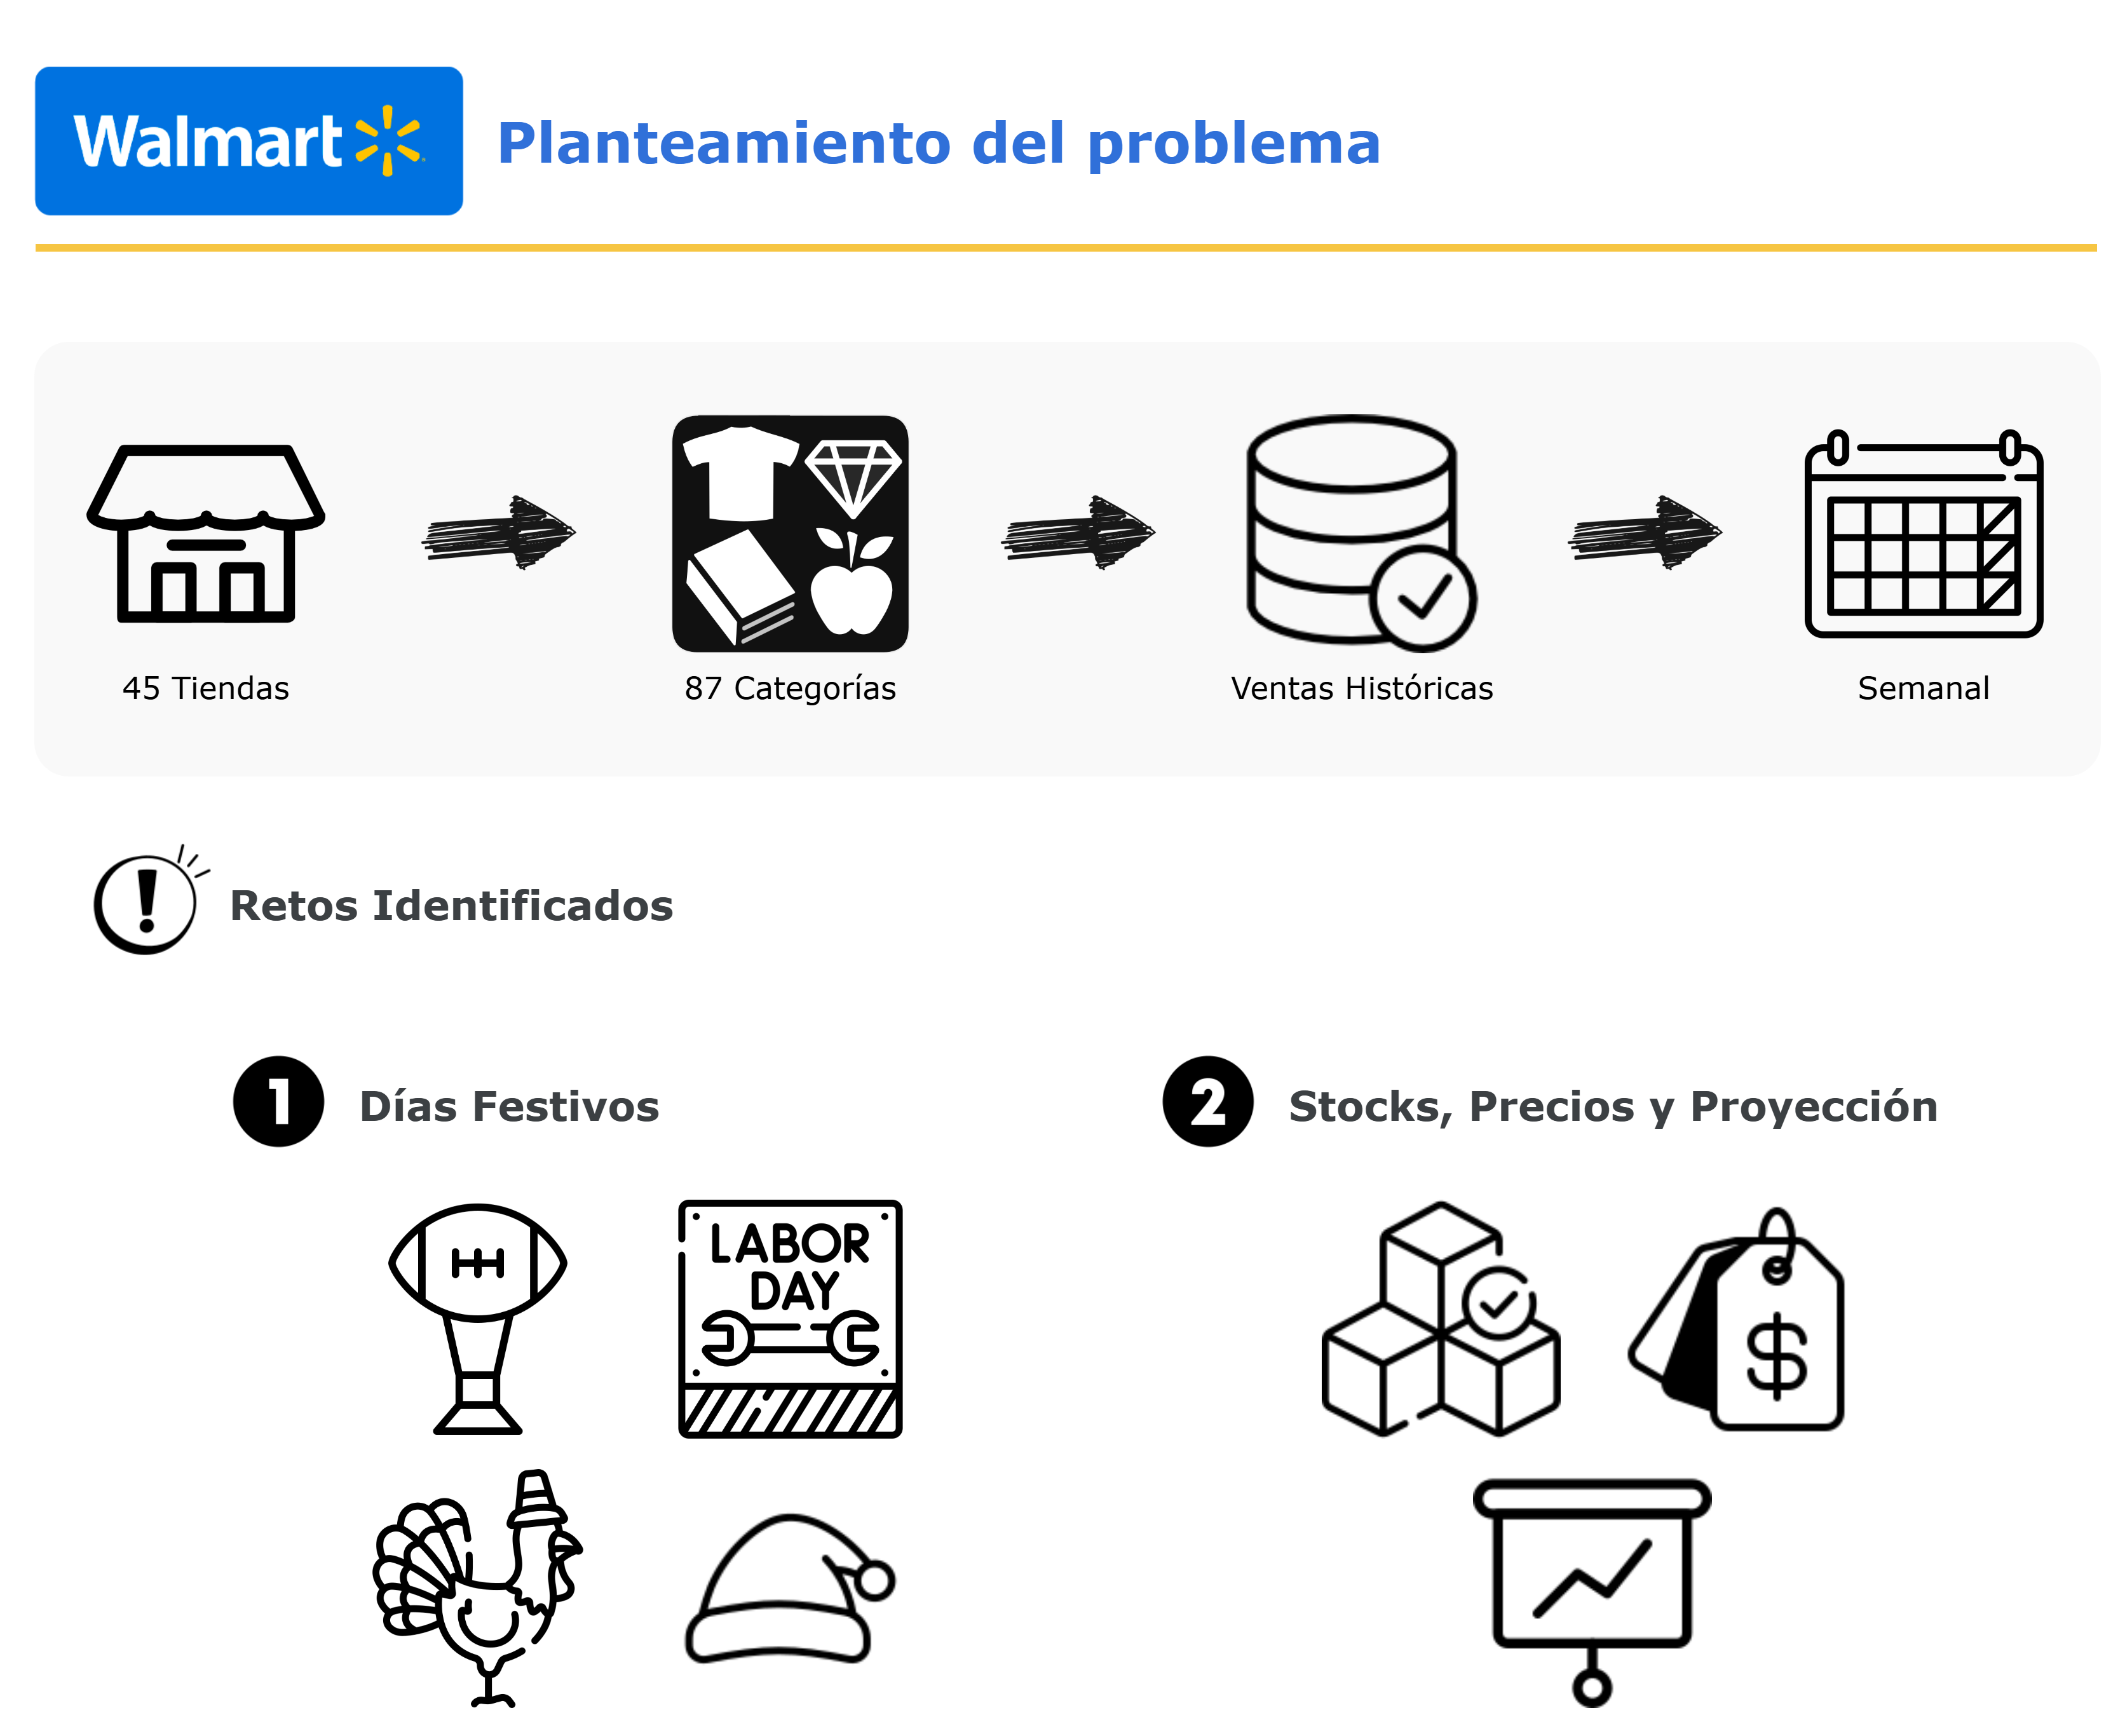

In [ ]:
# Planteamiento del problema


### 1.1 Objetivo

El objetivo principal de este proyecto es **estimar las ventas semanales por tienda** utilizando información histórica y variables externas relevantes, mediante el uso de técnicas de aprendizaje supervisado.

Objetivos Específicos

- Analizar la relación entre las ventas y variables económicas, climáticas y eventos especiales.
- Evaluar distintos enfoques de modelado predictivo para establecer referencias de desempeño.
- Comparar modelos simples y modelos de mayor complejidad con el fin de identificar aquel que ofrezca mejores estimaciones.
- Obtener un modelo que pueda servir como herramienta de apoyo para la planificación del área financiera y de marketing para que puedan hacer un plan de ventas con mayor facilidad.

## 2. Descripción general de los datos (Data Understanding)

Se cuenta con datos históricos de ventas, variables económicas y climáticas, así como información estructural de las tiendas.

### 2.1 Fuentes de datos

- **train.csv**:

    Datos históricos con ventas → dataset principal de entrenamiento, la data va desde el 05-02-2010 hasta el 01-11-2012 y tiene los campos:

    - Store - el número de tienda
    - Dept - número de departamento
    - Date - representación de la semana
    - Weekly_Sales - ventas del departamento en la tienda correspondiente
    - IsHoliday - si la semana es una semana especial de festividad

- **test.csv**:

    Datos sin ventas → dataset para predicción. Este archivo es idéntico a train.csv, salvo que no tenemos la data de las ventas semanales. Servirá para predecir las ventas de cada triplete de tienda, departamento y fecha en este archivo.

- **features.csv**:

    Variables económicas y climáticas.
    Este archivo contiene datos adicionales relacionados con la tienda, el departamento y la actividad para las fechas indicadas. Contiene los siguientes campos:

    - Store - el número de tienda
    - Date - la semana
    - Temperature - temperatura media en la región
    - Fuel_Price - coste del combustible en la región
    - MarkDown1-5 - datos relacionados con descuentos promocionales.
    - CPI - el índice de precios al consumidor
    - Unemployment: la tasa de desempleo
    - IsHoliday - si la semana es una semana especial de festividad

- **stores.csv**:

    Información sobre las 45 tiendas, indicando el tipo y tamaño de la tienda.

- **sampleSubmission.csv**:

    Formato esperado de salida (referencial)
    Para cada fila del conjunto de prueba (tienda + departamento + triplete de fecha), deberías predecir las ventas semanales de ese departamento. La columna Id se forma concatenando el Almacén, el Departamento y la Fecha con guiones bajos (por ejemplo, Store_Dept_2012-11-02)

### 2.2 Variable objetivo

- **Nombre**: Weekly_Sales, ventas semanales por tienda
- **Tipo**: Numérica
- **Unidad de predicción**: Semanal

### 2.3 Features

- **Variables Económicas**: 
    - Índices económicos (CPI)
    - Tasa de desempleo (Unemployment)
    - Precio del combustible (Fuel_Price)
- **Variables Climáticas**:
    - Temperatura promedio semanal (Temperature)
- **Eventos especiales**: 
    - Indicador de semanas festivas (IsHoliday)
- **Características de tienda**: 
    - Tipo de tienda (Type)
    - Tamaño de la tienda (Size)   
- **Temporalidad**: 
    - Fecha
    - Semana
    - Año

### 2.4 Tamaño y estructura del dataset

In [10]:
import pandas as pd
from pathlib import Path

def resumen_dataset(ruta_csv):
    """
    Genera un resumen básico del tamaño y estructura de un archivo CSV.
    """
    df = pd.read_csv(ruta_csv)
    
    resumen = {
        "archivo": Path(ruta_csv).name,
        "filas": df.shape[0],
        "columnas": df.shape[1],
        "columnas_numericas": df.select_dtypes(include="number").shape[1],
        "columnas_categoricas": df.select_dtypes(exclude="number").shape[1],
        "valores_nulos_totales": df.isnull().sum().sum(),
        "memoria_MB": round(df.memory_usage(deep=True).sum() / 1024**2, 2)
    }
    
    return resumen


# Lista de archivos de entrada
RUTA = "data/2.extracted/"
archivos = [
    "train.csv",
    "test.csv",
    "features.csv",
    "stores.csv",
    "sampleSubmission.csv"
]

# Generar resumen para cada archivo
resumenes = [resumen_dataset(RUTA + archivo) for archivo in archivos]

# Consolidar resultados en un DataFrame
df_resumen = pd.DataFrame(resumenes)

df_resumen


,archivo,filas,columnas,columnas_numericas,columnas_categoricas,valores_nulos_totales,memoria_MB
0,train.csv,421570,5,3,2,0,17.29
1,test.csv,115064,4,2,2,0,3.84
2,features.csv,8190,12,10,2,24040,0.77
3,stores.csv,45,3,2,1,0,0.00
4,sampleSubmission.csv,115064,2,1,1,0,3.47


## 3. Exploración inicial de los datos

El objetivo de esta sección es comprender la estructura del dataset, analizar el comportamiento de la variable objetivo y detectar posibles desafíos antes de la etapa de modelado.

### 3.1 Stores CSV

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

RUTA = "data/2.extracted/"

df_stores = pd.read_csv(RUTA + 'stores.csv')
print(df_stores.head())


   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875


In [2]:
df_stores.info()
print(df_stores.describe())
print(df_stores["Type"].value_counts())

<class 'pandas.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Store   45 non-null     int64
 1   Type    45 non-null     str  
 2   Size    45 non-null     int64
dtypes: int64(2), str(1)
memory usage: 1.2 KB
           Store           Size
count  45.000000      45.000000
mean   23.000000  130287.600000
std    13.133926   63825.271991
min     1.000000   34875.000000
25%    12.000000   70713.000000
50%    23.000000  126512.000000
75%    34.000000  202307.000000
max    45.000000  219622.000000
Type
A    22
B    17
C     6
Name: count, dtype: int64


<Axes: xlabel='Type', ylabel='Size'>

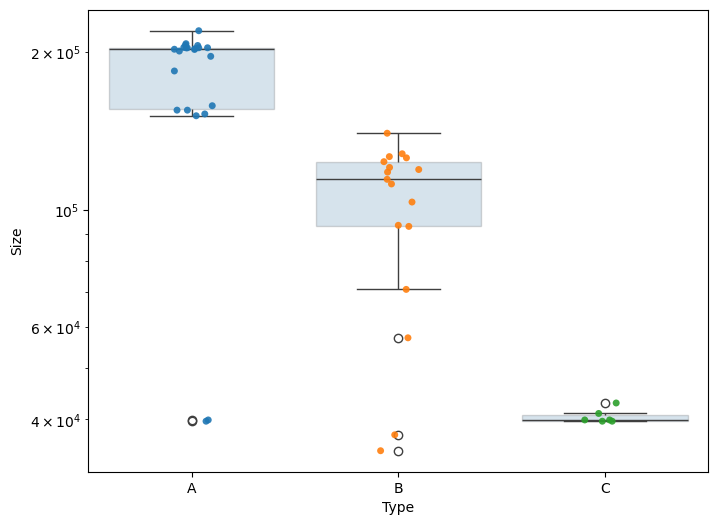

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(data=df_stores, x="Type", y="Size", ax=ax, boxprops=dict(alpha=0.2), log_scale=True)
sns.stripplot(data=df_stores, x="Type", y="Size", ax=ax, hue="Type", alpha=0.9, log_scale=True)

<Axes: xlabel='Type', ylabel='Store'>

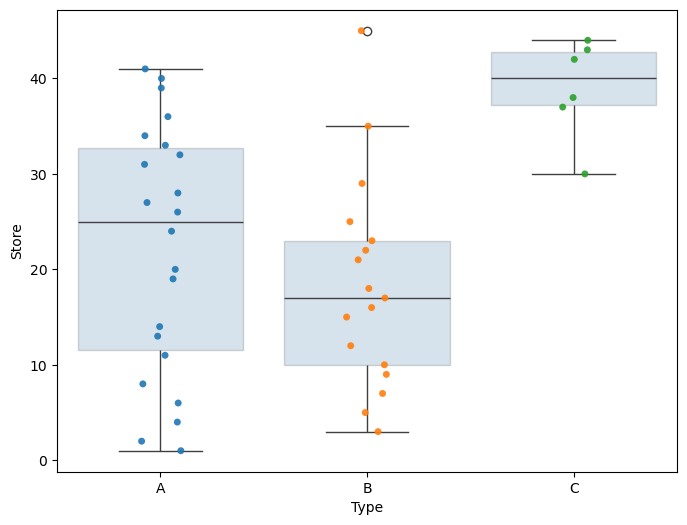

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(data=df_stores, x="Type", y="Store", ax=ax, boxprops=dict(alpha=0.2))
sns.stripplot(data=df_stores, x="Type", y="Store", ax=ax, hue="Type", alpha=0.9)

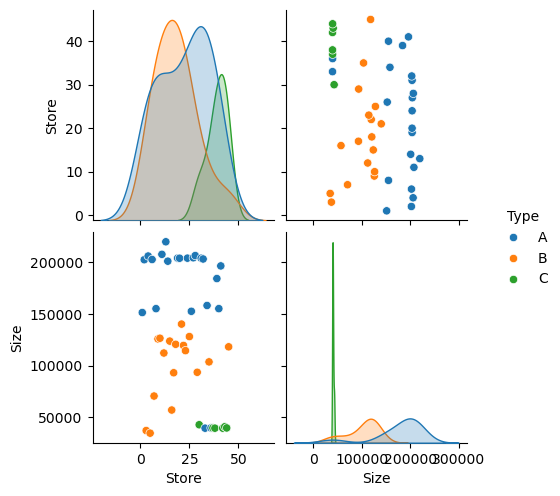

In [5]:
sns.pairplot(df_stores, hue="Type")

### 3.2 Train CSV

In [6]:
df_train = pd.read_csv(RUTA + 'train.csv')
print(df_train.head())

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False


In [7]:
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  str    
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), str(1)
memory usage: 17.3 MB


<Axes: >

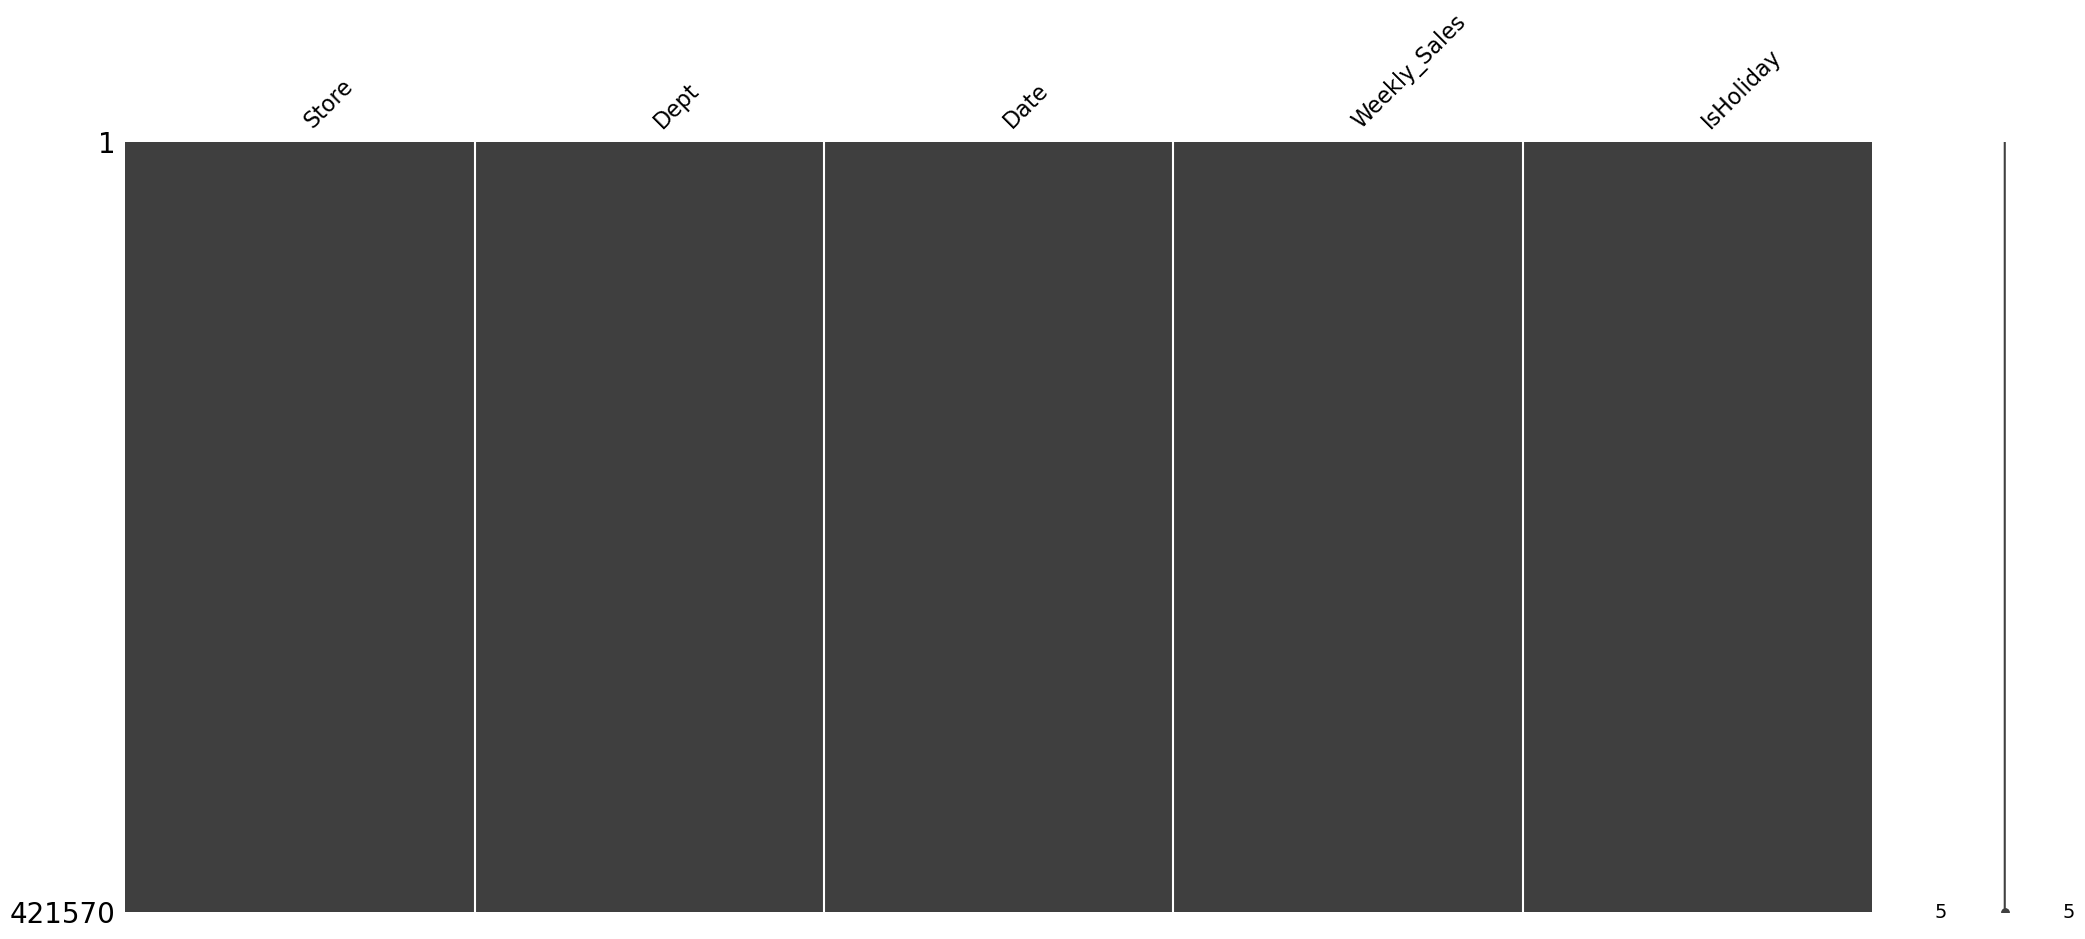

In [8]:
msno.matrix(df_train)

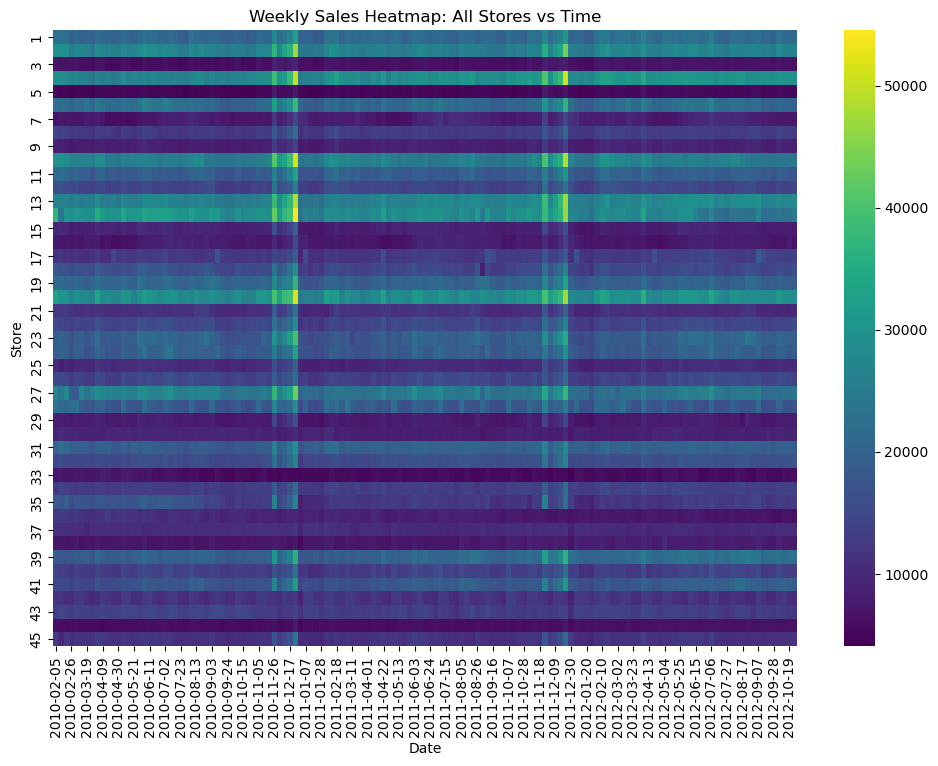

In [9]:
df_pivot = df_train.pivot_table(index="Store", columns="Date", values="Weekly_Sales")

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_pivot, cmap="viridis", ax=ax)

plt.title("Weekly Sales Heatmap: All Stores vs Time")
plt.show()

Text(0.5, 1.0, 'Sales Anomaly for Store 1, Dept 1')

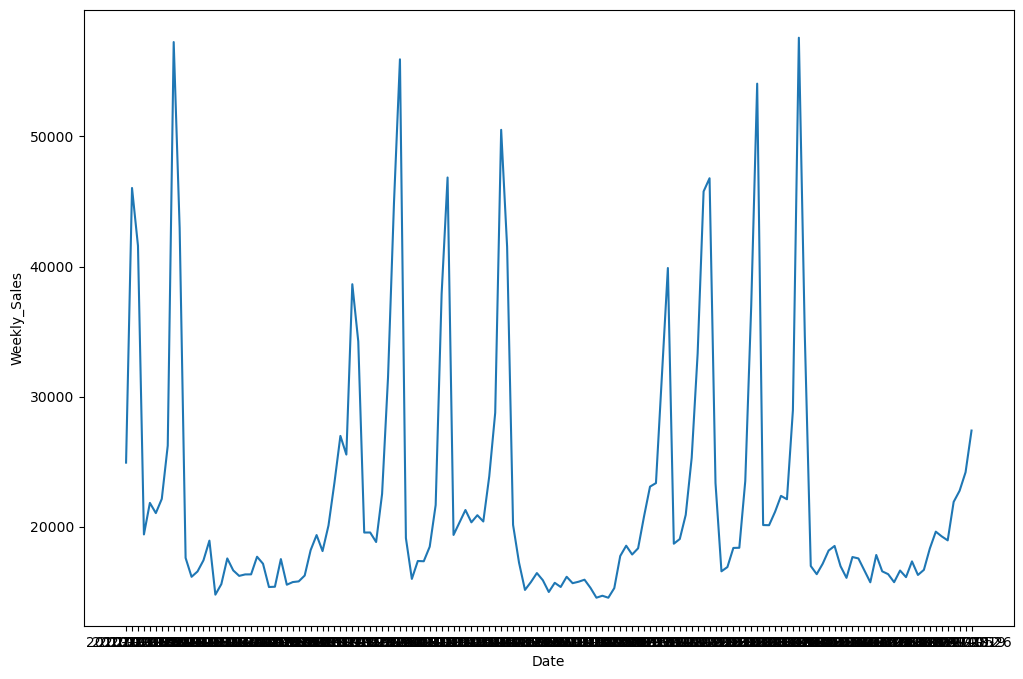

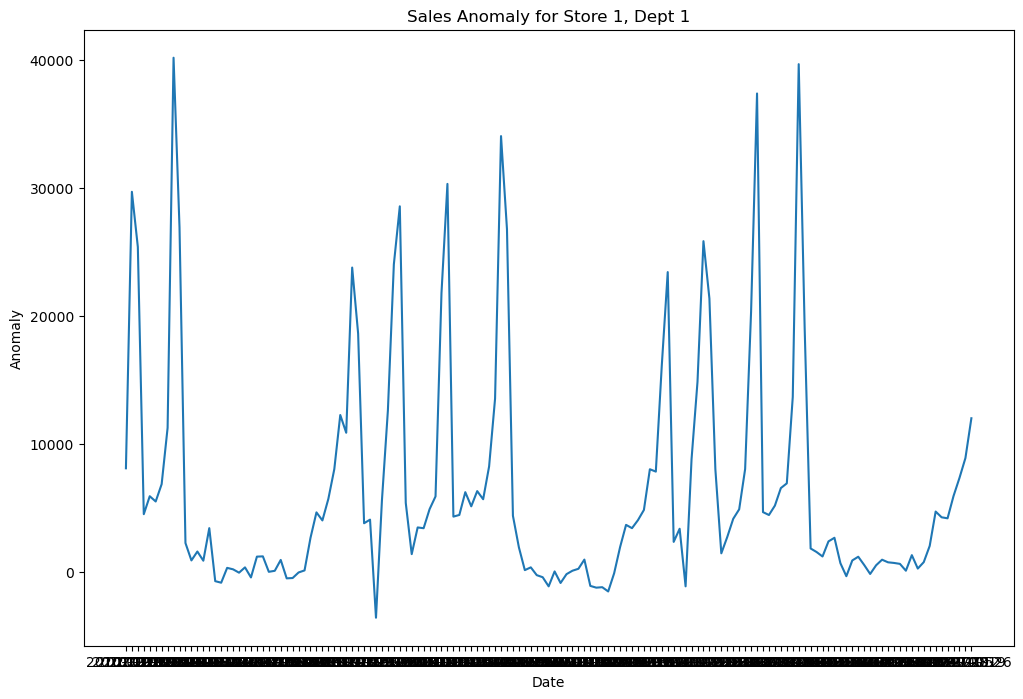

In [10]:
df_subset = df_train[(df_train["Store"] == 1 ) & (df_train["Dept"] == 1)]

fig,ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=df_subset, x="Date", y="Weekly_Sales", ax=ax)

df_climatology = df_train.groupby("Date")["Weekly_Sales"].mean().reset_index().rename(columns={"Weekly_Sales": "Climatology"})

df_plot = pd.merge(df_subset, df_climatology, on="Date")

df_plot["Anomaly"] = df_plot["Weekly_Sales"] - df_plot["Climatology"]

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=df_plot, x="Date", y="Anomaly", ax=ax)
plt.title("Sales Anomaly for Store 1, Dept 1")


In [11]:
df_plot

,Store,Dept,Date,Weekly_Sales,IsHoliday,Climatology,Anomaly
0,1,1,2010-02-05,24924.50,False,16836.121997,8088.378003
1,1,1,2010-02-12,46039.49,True,16352.056032,29687.433968
2,1,1,2010-02-19,41595.55,False,16216.658979,25378.891021
3,1,1,2010-02-26,19403.54,False,14899.549688,4503.990312
4,1,1,2010-03-05,21827.90,False,15921.015727,5906.884273
...,...,...,...,...,...,...,...
138,1,1,2012-09-28,18947.81,False,14765.327279,4182.482721
139,1,1,2012-10-05,21904.47,False,15983.413747,5921.056253
140,1,1,2012-10-12,22764.01,False,15427.596739,7336.413261
141,1,1,2012-10-19,24185.27,False,15295.732397,8889.537603


### 3.3 Test CSV

In [12]:
df_test = pd.read_csv(RUTA + 'test.csv')
print(df_test.head())

   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False


In [13]:
df_test.info()

<class 'pandas.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Store      115064 non-null  int64
 1   Dept       115064 non-null  int64
 2   Date       115064 non-null  str  
 3   IsHoliday  115064 non-null  bool 
dtypes: bool(1), int64(2), str(1)
memory usage: 3.8 MB


### 3.4 Features CSV

In [14]:
df_features = pd.read_csv(RUTA + 'features.csv')
print(df_features.head())

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  


In [15]:
df_features.info()

<class 'pandas.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   str    
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), str(1)
memory usage: 791.9 KB


<Axes: >

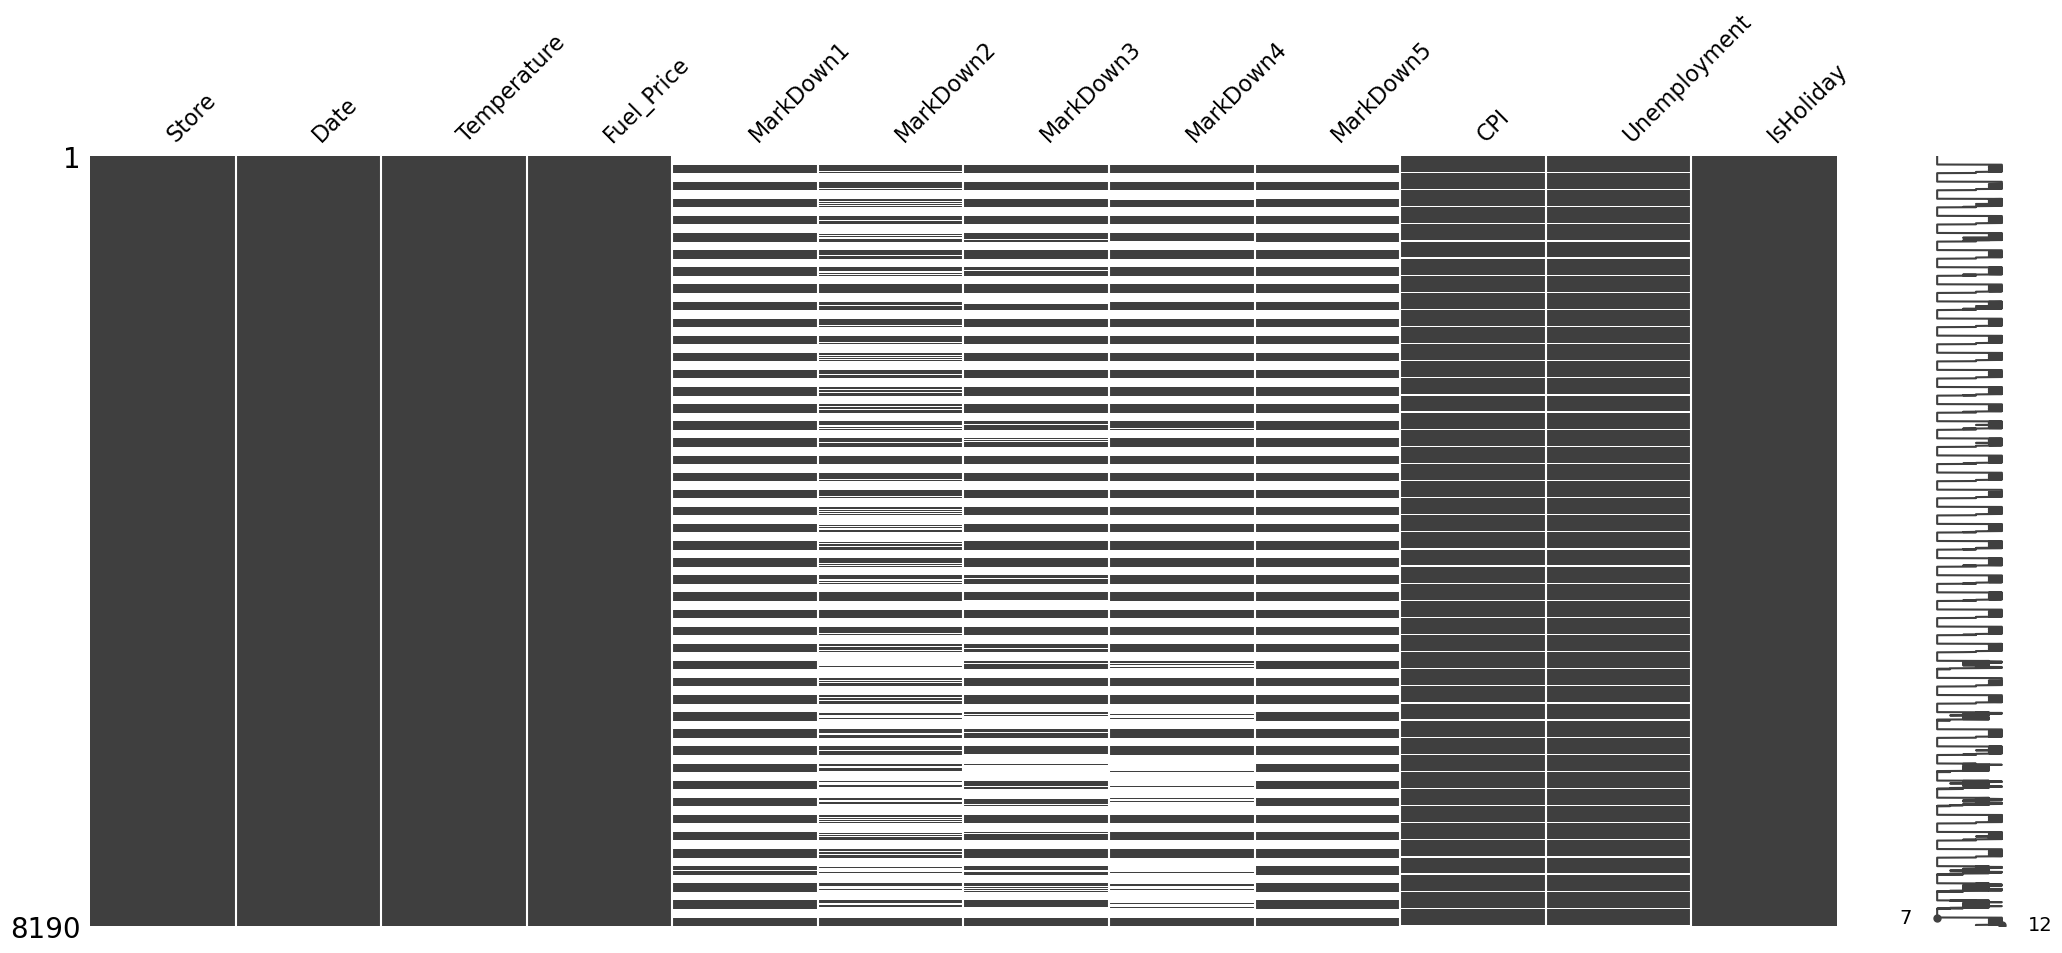

In [16]:
import missingno as msno

msno.matrix(df_features)

<Axes: >

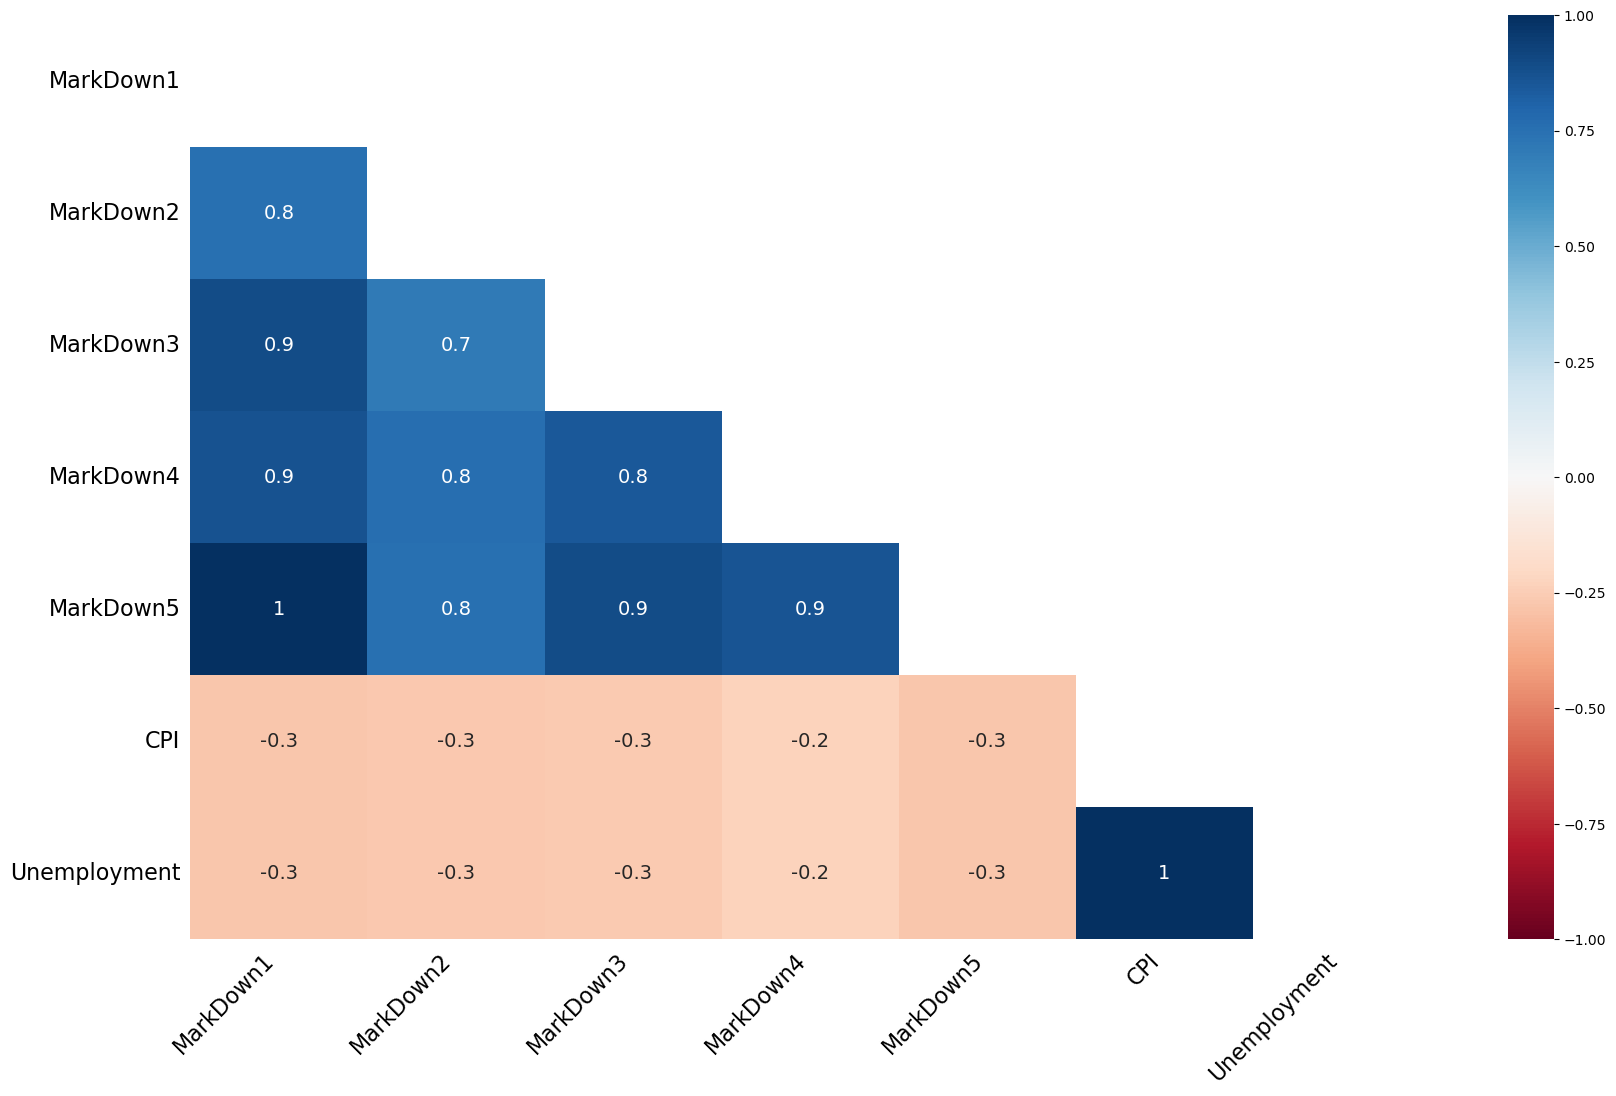

In [17]:
msno.heatmap(df_features)

In [18]:
df_features["MarkDown1"] = df_features["MarkDown1"].fillna(0)
df_features["MarkDown2"] = df_features["MarkDown2"].fillna(0)
df_features["MarkDown3"] = df_features["MarkDown3"].fillna(0)
df_features["MarkDown4"] = df_features["MarkDown4"].fillna(0)
df_features["MarkDown5"] = df_features["MarkDown5"].fillna(0)

<Axes: >

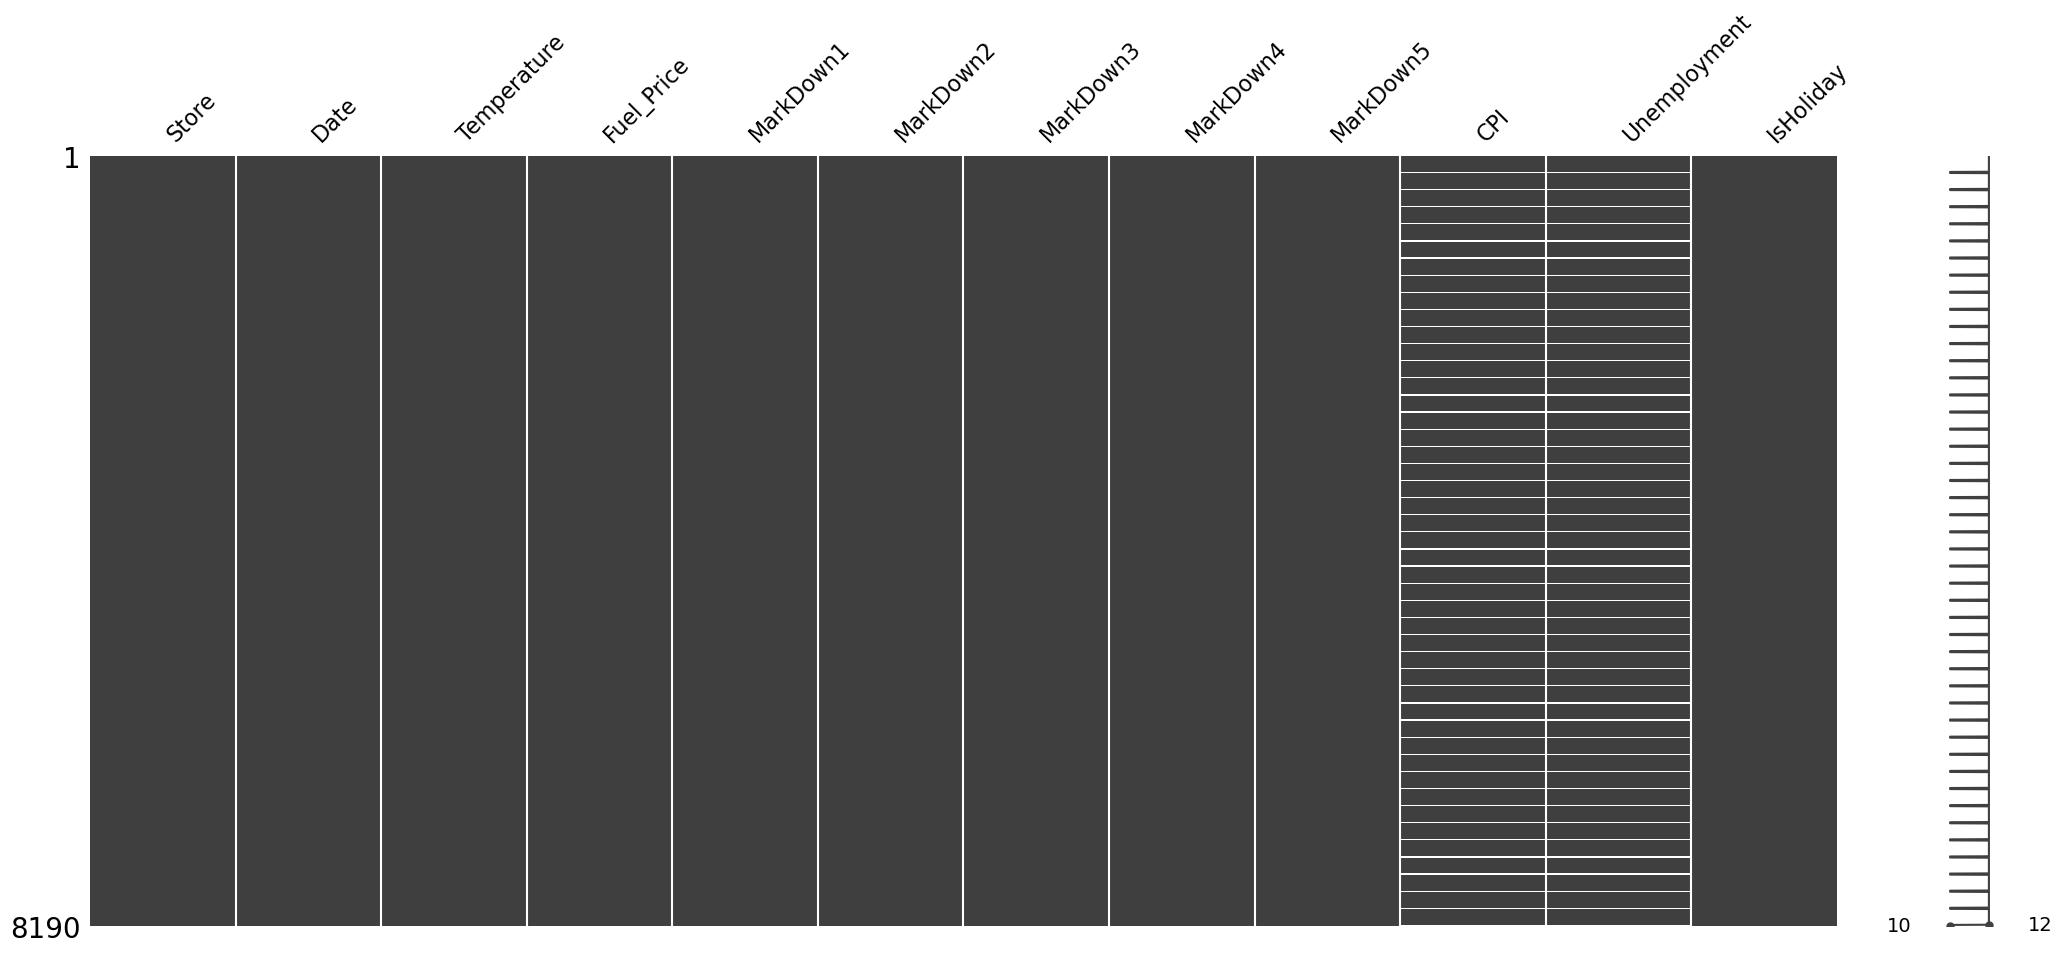

In [19]:
msno.matrix(df_features)

In [20]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)

imputed_data = imp.fit_transform(df_features[["CPI","Unemployment"]])

In [21]:
df_features = df_features.drop(columns=["CPI", "Unemployment"])
df_features[["CPI", "Unemployment"]] = imputed_data

<Axes: >

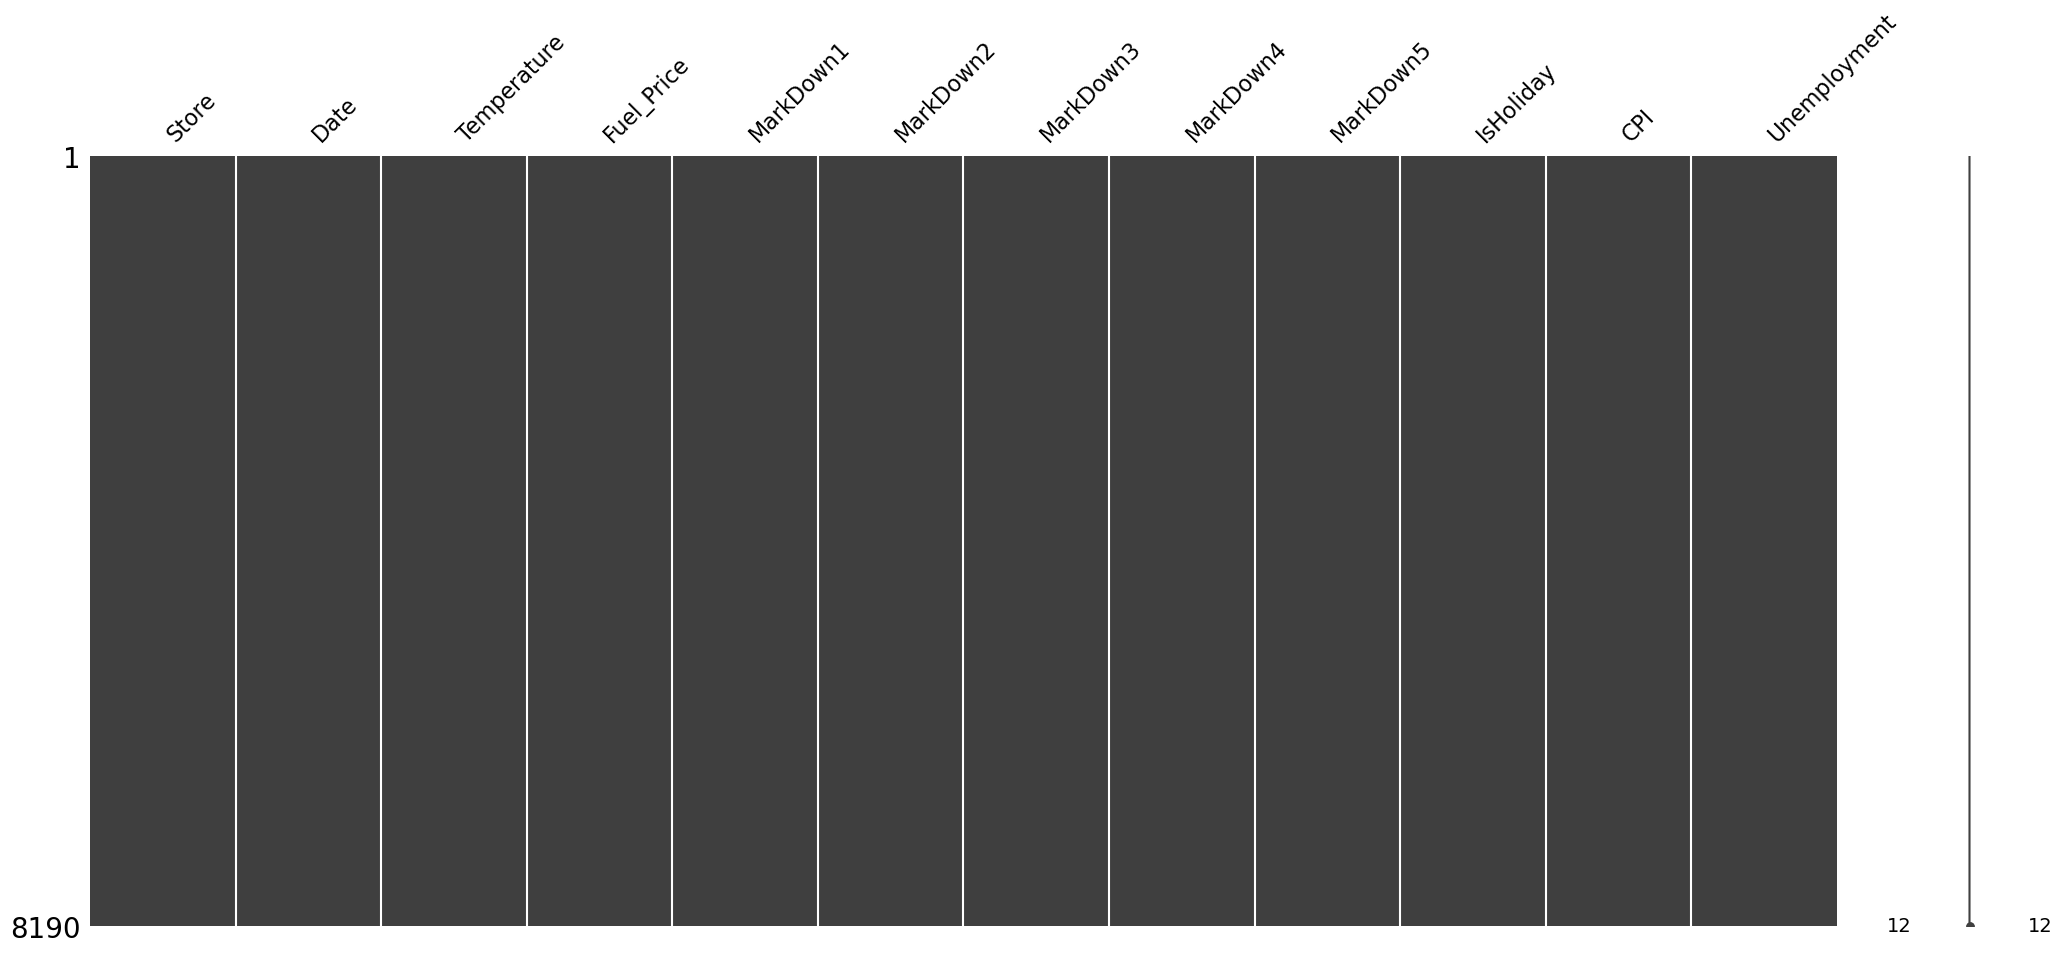

In [22]:
msno.matrix(df_features)

### 3.5 Joining Data

In [23]:
df_select_features = df_features[['Store','Date','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']]

df_train_with_feat = pd.merge(df_train, df_select_features, on=['Store', 'Date'], how='left')
print(df_train_with_feat.head())


   Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     1  2010-02-12      46039.49       True        38.51       2.548   
2      1     1  2010-02-19      41595.55      False        39.93       2.514   
3      1     1  2010-02-26      19403.54      False        46.63       2.561   
4      1     1  2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.242170   
2        0.0        0.0        0.0        0.0        0.0  211.289143   
3        0.0        0.0        0.0        0.0        0.0  211.319643   
4        0.0        0.0        0.0        0.0        0.0  211.350143   

   Unemployment  
0         8.106  
1         8.106  
2         8.106  
3         8.10

In [24]:
df_test_with_feat = pd.merge(df_test, df_select_features, on=['Store', 'Date'], how='left')
print(df_test_with_feat.head())

   Store  Dept        Date  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
0      1     1  2012-11-02      False        55.32       3.386    6766.44   
1      1     1  2012-11-09      False        61.24       3.314   11421.32   
2      1     1  2012-11-16      False        52.92       3.252    9696.28   
3      1     1  2012-11-23       True        56.23       3.211     883.59   
4      1     1  2012-11-30      False        52.34       3.207    2460.03   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  
0    5147.70      50.82    3639.90    2737.42  223.462779         6.573  
1    3370.89      40.28    4646.79    6154.16  223.481307         6.573  
2     292.10     103.78    1133.15    6612.69  223.512911         6.573  
3       4.17   74910.32     209.91     303.32  223.561947         6.573  
4       0.00    3838.35     150.57    6966.34  223.610984         6.573  


### 3.6 Save files

In [28]:
from pathlib import Path

RUTA_OUTPUT = Path("data/3.processed")

df_train_with_feat.to_parquet(RUTA_OUTPUT / "train_feat.parquet", index=False, engine="pyarrow")
df_test_with_feat.to_parquet(RUTA_OUTPUT / "test_feat.parquet", index=False, engine="pyarrow")


## 4. Consideraciones y desafíos del problema

Se identifican desafíos como variabilidad entre tiendas, presencia de eventos especiales y dependencia temporal.

El problema de predicción de ventas semanales presenta desafíos estructurales que influyen directamente en la elección del modelo y en su desempeño.

En primer lugar, existe una alta variabilidad entre tiendas y categorías, lo que introduce heterogeneidad en los datos. No todas las tiendas responden igual a factores económicos o estacionales, lo que dificulta la construcción de un modelo único que generalice perfectamente en todos los casos.

En segundo lugar, la presencia de eventos especiales, como semanas festivas, genera picos de demanda que no siguen un patrón lineal simple. Estos eventos introducen discontinuidades que deben modelarse explícitamente o ser capturadas mediante componentes estacionales.

Finalmente, la dependencia temporal es un componente dominante del problema. Las ventas semanales muestran patrones recurrentes y tendencias suaves, lo que implica que cualquier modelo que ignore la estructura temporal explícita tendrá limitaciones significativas.

Estos desafíos explican por qué no todos los enfoques predictivos presentan el mismo desempeño.

## 5. Enfoque de modelado

Se adopta una estrategia incremental, comenzando con modelos simples y avanzando hacia modelos más complejos.

El enfoque seguido fue:

1. Implementar modelos base para establecer referencias iniciales de desempeño.

2. Incorporar modelos basados en árboles para capturar no linealidades.

3. Evaluar un modelo de ensemble (AdaBoost) para modelar interacciones más complejas.

4. Comparar estos enfoques con un modelo estructural temporal (ETS).

La validación se realizó mediante un esquema temporal con 4 folds y 13 semanas de validación por bloque, evitando fuga de información y simulando condiciones reales de forecasting.

Las métricas utilizadas fueron WMAE (principal), MAE y RMSE, permitiendo evaluar tanto precisión promedio como sensibilidad ante valores extremos.

## 6. Modelos base

Se implementan modelos base para establecer puntos de comparación.

Entre ellos:

- Modelos lineales (Elastic Net)

- Modelos estructurales autoregresivos

- Modelos basados en árboles (Random Forest)

Los resultados mostraron que los modelos lineales presentan limitaciones para capturar la complejidad del fenómeno, especialmente en presencia de estacionalidad marcada y picos asociados a eventos festivos.

Random Forest mostró una mejora significativa respecto a modelos lineales, evidenciando la presencia de relaciones no lineales entre variables exógenas y ventas.

Sin embargo, el modelo ETS (estructural temporal) obtuvo el mejor desempeño global en términos de WMAE (1834.75), lo que sugiere que la estructura temporal explica una parte sustancial de la variabilidad del problema.

### 6.1 Model 1-lite: Local Linear Diagnostic Variant

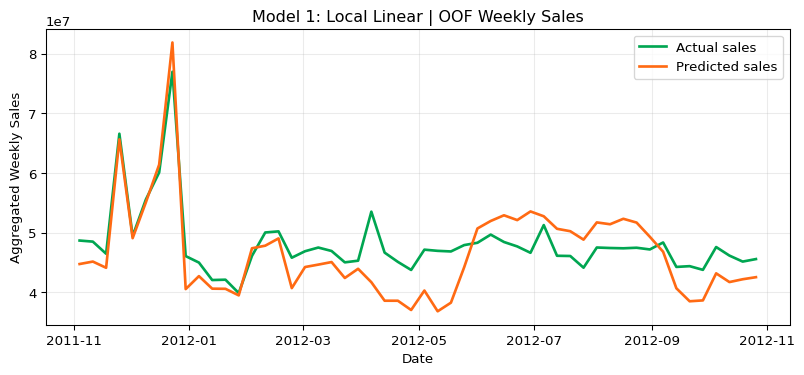

In [ ]:
# Graph

### 6.2 Model 2: Bayesian Structural AR

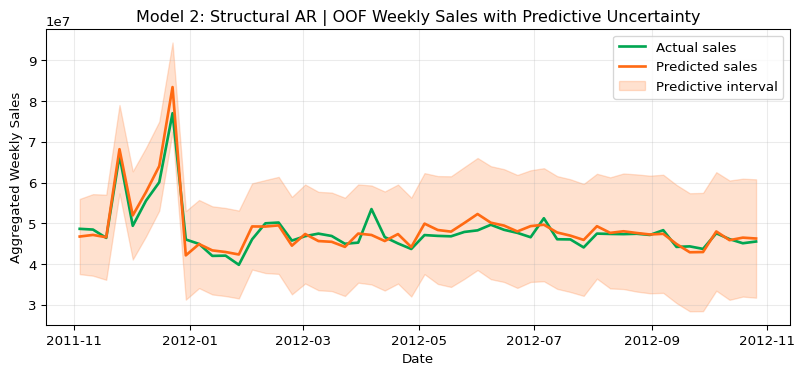

In [ ]:
# Graph


### 6.3 Model 3: Elastic Net Anomaly Baseline

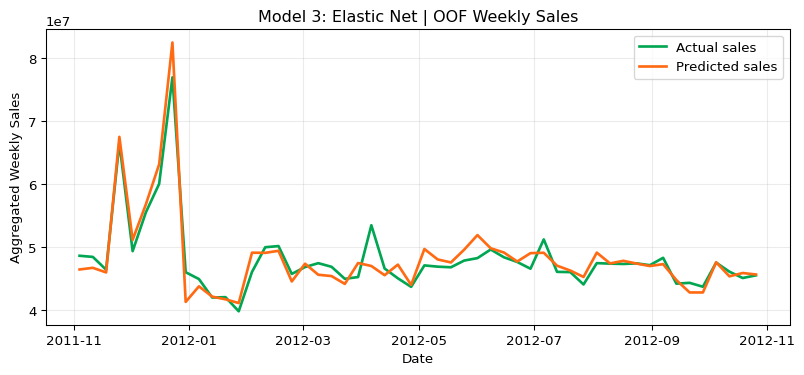

In [ ]:
# Graph

### 6.4 Model 4: Random Forest Anomaly Baseline

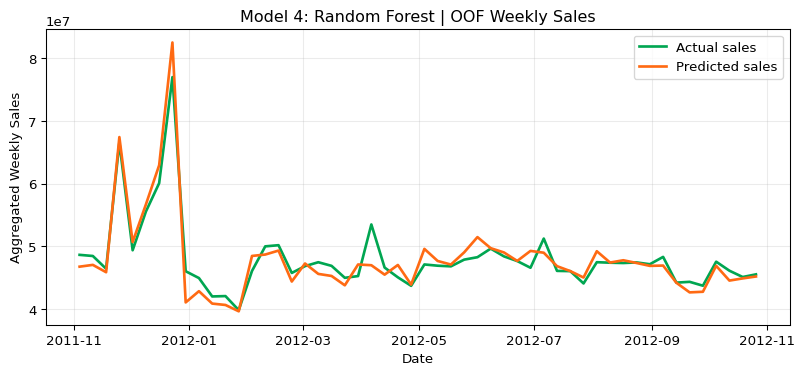

In [ ]:
# Graph

### 6.5 Model 5: ETS Anomaly Baseline

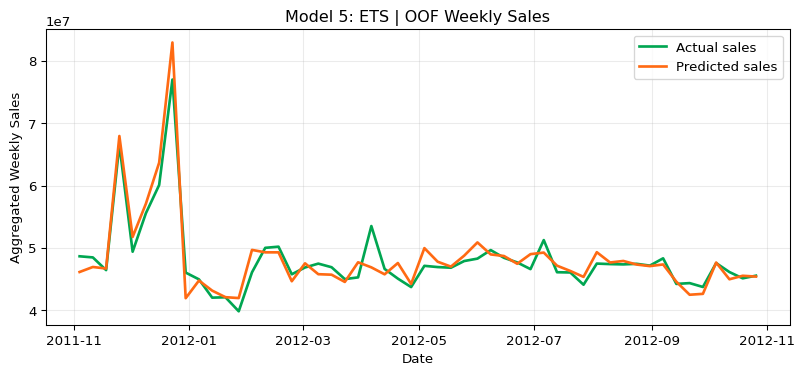

In [ ]:
# Graph

## 7. Modelo de ensemble: AdaBoost

Se incorpora AdaBoost para capturar relaciones no lineales y mejorar el desempeño predictivo.

Se implementó un modelo AdaBoost con el objetivo de capturar relaciones no lineales y modelar la componente de anomalía en las ventas.

La configuración utilizada fue:

- n_estimators = 300

- learning_rate = 0.03

- max_depth = 3

- Validación temporal en 4 folds

AdaBoost logró un WMAE promedio de 2139.38, mostrando mejoras respecto a modelos lineales simples, pero sin superar a Random Forest ni al modelo ETS.

Desde el punto de vista técnico, AdaBoost permitió capturar interacciones complejas entre variables económicas, promocionales y temporales. Sin embargo, al modelar principalmente la componente residual o anomalía, no logró capturar con la misma eficacia la estructura temporal dominante del fenómeno.

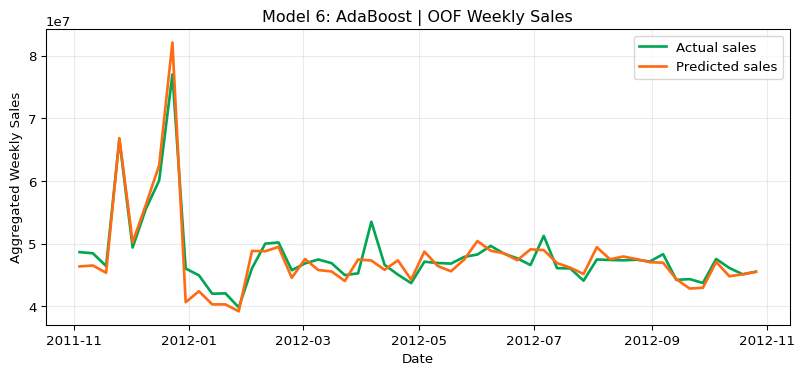

In [ ]:
# Model 6: AdaBoost Anomaly Baseline

## 8. Evaluación y análisis de resultados

Se comparan los modelos utilizando métricas apropiadas y se analizan sus resultados.

El análisis comparativo de los modelos revela tres conclusiones principales:

1. La estructura temporal es el componente dominante del problema, como lo demuestra el mejor desempeño del modelo ETS.

2. Los modelos basados en árboles mejoran sustancialmente el desempeño frente a enfoques lineales, confirmando la presencia de no linealidades.

3. AdaBoost resulta competitivo, pero no dominante, lo que indica que el boosting mejora la aproximación iterativa del error, pero no sustituye una modelización estructural explícita de la estacionalidad.

El uso de WMAE permitió evaluar el desempeño considerando la ponderación de errores, lo que resulta especialmente relevante en semanas festivas donde los errores absolutos pueden ser mayores.

En conjunto, los resultados muestran que la elección del modelo debe responder a la naturaleza del fenómeno y no únicamente a la complejidad algorítmica.

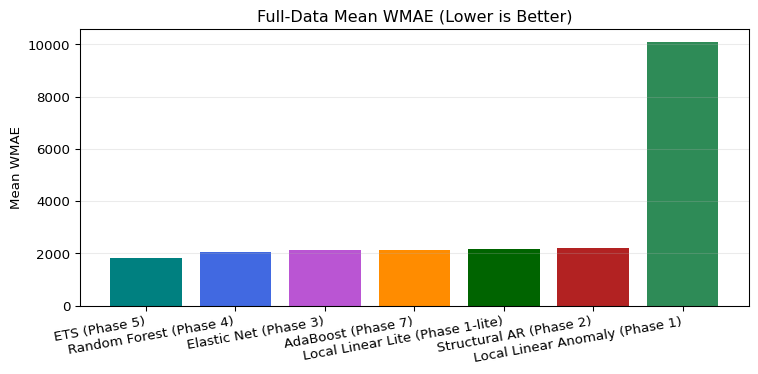

In [ ]:
# Comparación de modelos


## 9. Conclusiones y trabajo futuro

Se resumen los hallazgos principales y se plantean posibles mejoras futuras.

A partir del análisis desarrollado se concluye que:

- La predicción de ventas semanales en un entorno retail está fuertemente determinada por componentes temporales estructurales.

- Los modelos lineales son insuficientes para capturar la complejidad observada.

- Los modelos basados en árboles mejoran el desempeño, evidenciando interacciones no lineales.

- El modelo ETS obtiene el mejor desempeño general debido a su capacidad para modelar explícitamente nivel, tendencia y estacionalidad.

La selección del modelo no debe basarse únicamente en su sofisticación algorítmica, sino en su alineación con la estructura real del problema.

**Se proponen los siguientes pasos:**

- Integrar modelos híbridos que combinen estructura temporal (ETS) con aprendizaje de residuos mediante boosting.

- Explorar enfoques como Gradient Boosting o modelos basados en LightGBM.

- Incorporar validaciones temporales más extensas para evaluar estabilidad en horizontes mayores.

- Analizar efectos diferenciados por categoría para construir modelos segmentados.